# Linear Models

Look at removing outliers in price and area, especially given college orientation

# Explain the '<' pattern (article+data)
# Build geoapp where you can increase a radius centered at IU (Iowa State University), then see the predicted house prices + actual house prices. Once click on the house, can see the difference explained by examining that house's shap value! 
# Use CatBoost's Shap value to build a Dashboard

# Blend predictions??


In [1]:
KAGGLE=False # set to True if using the Kaggle version of the dataset

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import sklearn.preprocessing

from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn import preprocessing
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, HuberRegressor

from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [3]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 400)

The data has been pre-processed

In [4]:
def load_data(tree=None):
    if KAGGLE:
        train = pd.read_csv('data/train.csv')
        test = pd.read_csv('data/test.csv')
        num_train=np.shape(train)[0]
        num_test=np.shape(test)[0]
        alldata=train.append(test, ignore_index=True)
    else:
        alldata=pd.read_csv('./data/Ames_HousePriceLocsDistNoDpl.csv')#, index_col=0) #already cleaned (see work in appendix files)

        #alldata=pd.read_csv('./data/Ames_HousePriceLocsDistNoDpl.csv')#, index_col=0) #already cleaned (see work in appendix files)
    return alldata

alldata=load_data()

In [5]:
alldata.head()

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lats,longs,MissingLoc,distToUI
0,856,126000,30,RL,65.556308,7890,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,TA,4,Typ,1,Gd,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal,42.018564,-93.651619,0,0.620685
1,1049,139500,120,RL,42.000000,4235,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal,42.024855,-93.663671,0,0.890758
2,1001,124900,30,C (all),60.000000,6060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,9,1930,2007,Hip,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,Ex,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,Gd,5,Typ,0,NaN,Detchd,1930.0,Unf,1.0,216.0,TA,Po,N,154,0,42,86,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal,42.021548,-93.614068,0,1.702803
3,1039,114000,70,RL,80.000000,8146,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,Gd,BrkTil,Fa,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,Gd,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal,42.037391,-93.612207,0,1.909280
4,1665,227000,60,RL,70.000000,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,Ex,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal,42.044554,-93.631818,0,1.445916


In [6]:
nums = [col for col in alldata.columns if alldata.dtypes[col] != 'object']
cats = [col for col in alldata.columns if alldata.dtypes[col] == 'object']
alldata=pd.get_dummies(alldata).reset_index(drop=True)

In [7]:
alldata['LogPrice']=np.log1p(alldata.SalePrice)

In [8]:
alldata.distToUI.head()

0    0.620685
1    0.890758
2    1.702803
3    1.909280
4    1.445916
Name: distToUI, dtype: float64

In [9]:
# from sklearn.preprocessing import StandardScaler 
# scaler = StandardScaler()
# alldata = scaler.fit_transform(alldata)

In [10]:
alldata.head()

,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,lats,longs,MissingLoc,distToUI,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageF

In [11]:
def split_into_train_test(alldata):
    y=alldata['LogPrice']
    X=alldata.drop(['SalePrice','LogPrice'],axis=1)
    from sklearn.model_selection import train_test_split
    if KAGGLE:
        return split_train_test(alldata=alldata,num_train=num_train)
    else:
        return train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = split_into_train_test(alldata)  

# SIDENOTE START

In [ ]:
#RF ON dummified: Worse!

In [125]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
run_model(model_rf,X_train,y_train,X_test,y_test)

RMSE on Test: 0.12983894073158073
R^2 on Test: 0.8916232584583484


RandomForestRegressor()

In [ ]:
#SIDENOTE END

The sale price appears to be skewed to the right

In [12]:
# from sklearn.pipeline import make_pipeline 
# from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# pipe = make_pipeline(OneHotEncoder(),StandardScaler(),PolynomialFeatures(3),LinearRegression())
# run_model(pipe,X_train,y_train,X_test,y_test)

In [13]:
def run_model(model,X_train,y_train,X_test,y_test):
    
    # Fit Model
    model.fit(X_train,y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print(f'RMSE on Test: {rmse}')
    r2 = r2_score(y_test, preds)
    print(f'R^2 on Test: {r2}')

    return model

### Without log price

In [14]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
run_model(model_lr,X_train,y_train,X_test,y_test)

RMSE on Test: 1568.3340736844364
R^2 on Test: -15812600.201752799


LinearRegression()

### With log price

In [15]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
run_model(model_lr,X_train,y_train,X_test,y_test)

RMSE on Test: 1568.3340736844364
R^2 on Test: -15812600.201752799


LinearRegression()

#### Size-related columns

In [18]:
size_related = alldata.filter(regex='SF$|Area$')


In [19]:
size_related.head()

,GrLivArea,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GarageArea,WoodDeckSF,OpenPorchSF,PoolArea
0,856,7890,0.0,618.0,856.0,856,0,0,399.0,0,0,0
1,1049,4235,149.0,104.0,1049.0,1049,0,0,266.0,0,105,0
2,1001,6060,0.0,100.0,837.0,1001,0,0,216.0,154,0,0
3,1039,8146,0.0,405.0,405.0,717,322,0,281.0,0,0,0
4,1665,8400,0.0,167.0,810.0,810,855,0,528.0,0,45,0


In [20]:
size_cols=set(size_related.columns)

#### Neighborhood columns

In [21]:
ngh_related = alldata.filter(regex='^Neighborhood')


In [22]:
ngh_related.head()

,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [23]:
ngh_cols=set(ngh_related.columns)

#### Condition columns

In [24]:
cond_related = alldata.filter(regex='^Condition|^ExterCond|^BsmtCond')


In [25]:
cond_related.head()

,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [26]:
cond_cols=set(cond_related.columns)

In [27]:
qual_related = alldata.filter(regex='^KitchenQual')  #|^BasementQual')


In [28]:
qual_related.head()

,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,1,0,0


In [29]:
qual_cols=set(qual_related.columns)

In [30]:
street_related = alldata.filter(regex='^Street')


In [31]:
street_related.head()

,Street_Grvl,Street_Pave
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [32]:
street_cols=set(street_related.columns)

#### Garage-related columns

In [33]:
garage_related = alldata.filter(regex='^Garage') #extra cols will be dropped when we make the set


In [34]:
garage_related.head()

,GarageYrBlt,GarageCars,GarageArea,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA
0,1939.0,2.0,399.0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1
1,1984.0,1.0,266.0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,1930.0,1.0,216.0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
3,1940.0,1.0,281.0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1
4,2001.0,2.0,528.0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [35]:
garage_cols=set(garage_related.columns)

In [36]:
air_related = alldata.filter(regex='^Central') #extra cols will be dropped when we make the set


In [37]:
air_related.head()

,CentralAir_N,CentralAir_Y
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [38]:
air_cols=set(air_related.columns)

In [39]:
fireplace_related = alldata.filter(regex='^Fireplace') #extra cols will be dropped when we make the set


In [40]:
fireplace_related.head()

,Fireplaces,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA
0,1,0,0,1,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [41]:
fireplace_cols=set(fireplace_related.columns)

In [42]:
salecondition_related = alldata.filter(regex='^SaleCondition') #extra cols will be dropped when we make the set


In [43]:
salecondition_related.head()

,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0


In [44]:
salecondition_cols=set(salecondition_related.columns)

In [45]:
ssnporch_related = alldata.filter(regex='^3SsnPorch') #extra cols will be dropped when we make the set


In [46]:
ssnporch_related.head()

,3SsnPorch
0,0
1,0
2,86
3,0
4,0


In [47]:
ssnporch_cols=set(ssnporch_related.columns)

In [48]:
extrqual_related = alldata.filter(regex='^ExterQual') #extra cols will be dropped when we make the set


In [49]:
extrqual_related.head()

,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [50]:
extrqual_cols=set(extrqual_related.columns)

In [51]:
zoning_related = alldata.filter(regex='^MSZoning') #extra cols will be dropped when we make the set

In [52]:
zoning_related.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0


In [53]:
zoning_cols=set(zoning_related.columns)

In [54]:
bldg_related = alldata.filter(regex='^BuildingType') #extra cols will be dropped when we make the set

In [55]:
bldg_related.head()

""
0
1
2
3
4


In [56]:
bldg_cols=set(bldg_related.columns)

In [57]:
feature_imp_cols=set(['OverallQual','OverallCond','lats','longs','YearBuilt','YearRemodAdd','GarageCars','Fireplaces','LotArea','LotFrontage'])#,'BsmtFullBath'])

In [58]:
alldata.head()

,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,lats,longs,MissingLoc,distToUI,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageF

In [59]:
alldata.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       ...
       'SaleType_Oth', 'SaleType_VWD', 'SaleType_WD ', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'LogPrice'],
      dtype='object', length=299)

In [60]:
price_col=set(['LogPrice','SalePrice']) #will be dropped in train-valid split

In [148]:
final_cols=size_cols|price_col|feature_imp_cols#|ngh_cols|cond_cols|extrqual_cols|qual_cols|street_cols|garage_cols|air_cols|bldg_cols|set(['distToUI'])#|basement_kitchen_cols#|zoning_cols#|ssnporch_cols#|fireplace_cols|salecondition_cols

In [149]:
#final_cols=size_cols|ngh_cols|price_col

In [150]:
final_cols

{'1stFlrSF',
 '2ndFlrSF',
 'BsmtUnfSF',
 'Fireplaces',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'LogPrice',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'SalePrice',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'lats',
 'longs'}

In [151]:
### Pipeline

In [152]:
X_train, X_test, y_train, y_test = split_into_train_test(alldata[list(final_cols)])  

In [153]:
model_lr = LinearRegression()
#pipe = make_pipeline(StandardScaler(),PolynomialFeatures(2),LinearRegression())

run_model(model_lr,X_train,y_train,X_test,y_test)

RMSE on Test: 0.1339327095138833
R^2 on Test: 0.8846813706860629


LinearRegression()

In [110]:
#Get much higher R^2 if remove all houses with outliers
import numpy as np
from scipy import stats
alldata_=alldata[(np.abs(stats.zscore(alldata[['LogPrice']])) < 3).all(axis=1)]

In [111]:
np.shape(alldata_)

(2540, 299)

In [146]:
X_train, X_test, y_train, y_test = split_into_train_test(alldata_[list(final_cols)])  

In [147]:
model_lr = LinearRegression()
pipe = make_pipeline(LinearRegression())

run_model(pipe,X_train,y_train,X_test,y_test)

RMSE on Test: 0.10553942957022987
R^2 on Test: 0.9170511598405022


Pipeline(steps=[('linearregression', LinearRegression())])

In [163]:
model_lr = HuberRegressor()
run_model(model_lr,X_train,y_train,X_test,y_test)

RMSE on Test: 0.15901004997219753
R^2 on Test: 0.8374543655185717


HuberRegressor()

In [144]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')


cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model.fit(X_train, y_train)


ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             l1_ratio=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
             n_jobs=-1, normalize=True)

## Running on the entire columns list

In [50]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')

#def run_elastic()
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model2 = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model2.fit(X_train, y_train)


In [13]:
preds = model2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
print(f'RMSE on Test: {rmse}')
r2 = r2_score(y_test, preds)
print(f'R^2 on Test: {r2}')

RMSE on Test: 0.1102043330301408
R^2 on Test: 0.9219229307632664


In [29]:
residuals = y_test - preds

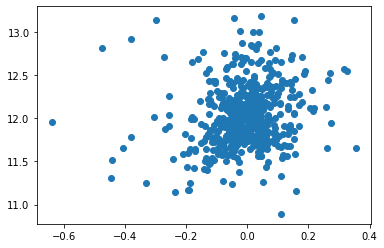

In [31]:
plt.scatter(residuals,preds)

In [32]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

In [69]:
def plot_resids():
    model=ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()    

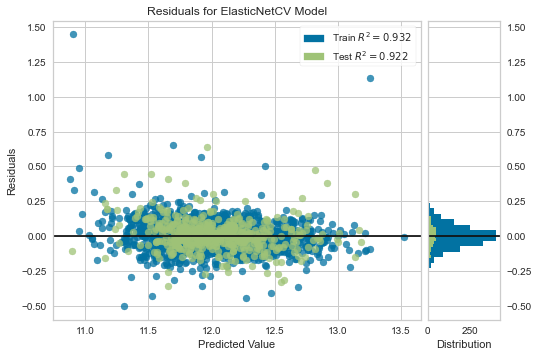

<AxesSubplot:title={'center':'Residuals for ElasticNetCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [34]:
model3=ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
visualizer = ResidualsPlot(model3)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()    

In [68]:
def plot_qq(model):
    model=ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
    visualizer = ResidualsPlot(model,hist=False,qqplot=True)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()    

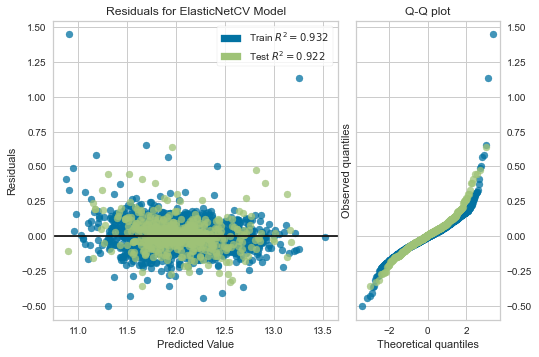

<AxesSubplot:title={'center':'Residuals for ElasticNetCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [36]:
model3=ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
visualizer = ResidualsPlot(model3,hist=False,qqplot=True)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()    

In [19]:
elastic_coefs=list(zip(model2.coef_,X_train.columns))

len(elastic_coefs)

#elastic_coefs_=
elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

len(elastic_coefs_)

sorted(elastic_coefs_,key=lambda x:x[1], reverse=True)

In [40]:
elastic_var_names=[x[0] for x in elastic_coefs_]

In [13]:
#Helpful code: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
def print_vifs():
    from statsmodels.stats.outliers_influence import variance_inflation_factor


    vif_data = pd.DataFrame()
    vif_data["feature"] = elastic_var_names

    vif_data["VIF"] = [variance_inflation_factor(alldata[elastic_var_names].values, i)
                              for i in range(len(alldata[elastic_var_names].columns))]

    print(vif_data)
#print_vifs()

In [14]:
statsmodels.stats.outliers_influence??

Object `statsmodels.stats.outliers_influence` not found.


In [23]:
#Helpful code: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
def print_vifs():
    from statsmodels.stats.outliers_influence import variance_inflation_factor


    vif_data = pd.DataFrame()
    vif_data["feature"] = elastic_var_names

    vif_data["VIF"] = [variance_inflation_factor(alldata[elastic_var_names].values, i)
                              for i in range(len(alldata[elastic_var_names].columns))]

    print(vif_data)
#print_vifs()

In [25]:
import pickle
pickle.dump(model2, open('./models/model_elastic', 'wb'))


In [15]:
def split_drop_train_test(alldata,drop=[]):
    y=alldata['LogPrice']
    X=alldata.drop(['SalePrice','LogPrice']+drop,axis=1)
    from sklearn.model_selection import train_test_split
    if KAGGLE:
        return split_train_test(alldata=alldata,num_train=num_train)
    else:
        return train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = split_into_train_test(alldata)  

In [124]:
X_train, X_test, y_train, y_test = split_drop_train_test(alldata,drop=['2ndFlrSF','Exterior2nd_PreCast'])#,'CentralAir_Y'])#,'Exterior1st_PreCast'])  

In [125]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model3 = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model3.fit(X_train, y_train)

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             l1_ratio=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
             n_jobs=-1, normalize=True)

In [20]:
def eval_results(model):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print(f'RMSE on Test: {rmse}')
    r2 = r2_score(y_test, preds)
    print(f'R^2 on Test: {r2}')

In [127]:
preds = model3.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
print(f'RMSE on Test: {rmse}')
r2 = r2_score(y_test, preds)
print(f'R^2 on Test: {r2}')

RMSE on Test: 0.11048380158473162
R^2 on Test: 0.921526435416841


In [128]:
elastic_coefs=list(zip(model3.coef_,X_train.columns))

elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

elastic_var_names=[x[0] for x in elastic_coefs_]

#elastic_var_names

print_vifs()

# Try Log-Log

# College ElasticNet After Remove High Prices

In [12]:
#Get much higher R^2 if remove all houses with outliers
import numpy as np
from scipy import stats
alldata_=alldata[(np.abs(stats.zscore(alldata[['LogPrice']])) < 2.5).all(axis=1)]

In [14]:
def split_drop_train_test(alldata,drop=[]):
    y=alldata['LogPrice']
    X=alldata.drop(['SalePrice','LogPrice']+drop,axis=1)
    from sklearn.model_selection import train_test_split
    if KAGGLE:
        return split_train_test(alldata=alldata,num_train=num_train)
    else:
        return train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
X_train, X_test, y_train, y_test = split_drop_train_test(alldata_,drop=['2ndFlrSF'])#,'2ndFlrSF','Exterior2nd_PreCast''CentralAir_Y'])#,'Exterior1st_PreCast'])  

In [149]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model4 = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model4.fit(X_train, y_train)

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             l1_ratio=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
             n_jobs=-1, normalize=True)

In [150]:
eval_results(model4)

RMSE on Test: 0.09700919260141173
R^2 on Test: 0.9299179797386112


In [151]:
elastic_coefs=list(zip(model4.coef_,X_train.columns))

elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

elastic_var_names=[x[0] for x in elastic_coefs_]

#elastic_var_names

print_vifs()

                   feature        VIF
0                GrLivArea   8.618162
1              LotFrontage   2.450688
2                  LotArea   1.893542
3              OverallQual   4.119725
4              OverallCond   1.998155
5                YearBuilt   9.757746
6             YearRemodAdd   2.861509
7               MasVnrArea   1.645644
8               BsmtFinSF1   2.947581
9               BsmtFinSF2   1.609421
10             TotalBsmtSF   5.677502
11                1stFlrSF   5.803352
12            BsmtFullBath   2.093586
13                FullBath   3.050164
14                HalfBath   2.401897
15            KitchenAbvGr   2.369897
16            TotRmsAbvGrd   3.987657
17              Fireplaces   2.032524
18             GarageYrBlt   5.411342
19              GarageCars   6.565428
20              GarageArea   6.363936
21              WoodDeckSF   1.312749
22             OpenPorchSF   1.291529
23           EnclosedPorch   1.283956
24               3SsnPorch   1.041306
25          

In [17]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')

In [32]:
def report_results(data=alldata_,drop=['2ndFlrSF','CentralAir_N','Utilities_NoSewr','Utilities_AllPub']):
    X_train, X_test, y_train, y_test = split_drop_train_test(alldata=alldata_,drop=drop)#,'GarageYrBlt'])#,'GarageYrBlt'])#,'GarageCars'])#,'MSZoning_RL'])#,'Utilities_NoSewr'])#,'2ndFlrSF','Exterior2nd_PreCast''CentralAir_Y'])#,'Exterior1st_PreCast'])  

    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    # define model
    ratios = np.arange(0, 1, 0.01)
    alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
    model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
    # fit model
    model=model.fit(X_train, y_train)
    eval_results(model)
    #get coef names
    elastic_coefs=list(zip(model.coef_,X_train.columns))

    elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

    elastic_var_names=[x[0] for x in elastic_coefs_]

    print_vifs()
    
    print(sorted(elastic_coefs,key=lambda x:x[1], reverse=True))#change back to _
    
    return model

In [15]:
X_train, X_test, y_train, y_test = split_drop_train_test(alldata_,drop=['2ndFlrSF','CentralAir_N','Utilities_NoSewr','Utilities_AllPub'])#,'GarageYrBlt'])#,'GarageYrBlt'])#,'GarageCars'])#,'MSZoning_RL'])#,'Utilities_NoSewr'])#,'2ndFlrSF','Exterior2nd_PreCast''CentralAir_Y'])#,'Exterior1st_PreCast'])  

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model5 = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model5.fit(X_train, y_train)

In [21]:
eval_results(model5)

RMSE on Test: 0.09100370216611023
R^2 on Test: 0.9320720227716836


In [25]:
elastic_coefs=list(zip(model5.coef_,X_train.columns))

elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

elastic_var_names=[x[0] for x in elastic_coefs_]

#elastic_var_names

print_vifs()



                   feature         VIF
0                GrLivArea   11.788464
1              LotFrontage    2.527089
2                  LotArea    1.957745
3              OverallQual    4.360590
4              OverallCond    2.065847
5                YearBuilt   11.422058
6             YearRemodAdd    2.934797
7               MasVnrArea    1.742189
8               BsmtFinSF1    3.213264
9               BsmtFinSF2    1.649023
10             TotalBsmtSF    5.647334
11                1stFlrSF    7.910674
12            LowQualFinSF    1.158369
13            BsmtFullBath    2.136349
14                FullBath    3.191440
15                HalfBath    2.504214
16            KitchenAbvGr    3.472793
17            TotRmsAbvGrd    4.083172
18              Fireplaces    2.096811
19             GarageYrBlt    5.536315
20              GarageCars    6.651148
21              GarageArea    6.412379
22              WoodDeckSF    1.338307
23             OpenPorchSF    1.309491
24           EnclosedPorc

In [26]:
elastic_coefs5=list(zip(model5.coef_,X_train.columns))

len(elastic_coefs5)

#elastic_coefs_=
elastic_coefs5_=[(coef[1],coef[0]) for coef in elastic_coefs5 if abs(coef[0])>0]

len(elastic_coefs5_)

sorted(elastic_coefs5,key=lambda x:x[1], reverse=True)#change back to _

[(0.0, 'longs'),
 (-0.0, 'lats'),
 (-1.3338746713348387e-06, 'distToUI'),
 (-0.0, 'YrSold'),
 (0.0007312953561685371, 'YearRemodAdd'),
 (0.001206258677547179, 'YearBuilt'),
 (3.85712057387708e-05, 'WoodDeckSF'),
 (7.349945079006288e-05, 'TotalBsmtSF'),
 (0.008071754265450256, 'TotRmsAbvGrd'),
 (0.02020302261230589, 'Street_Pave'),
 (-0.020215601123225256, 'Street_Grvl'),
 (0.00011968605169829893, 'ScreenPorch'),
 (-0.0, 'SaleType_WD '),
 (-0.0, 'SaleType_VWD'),
 (-0.04455719619975689, 'SaleType_Oth'),
 (0.0, 'SaleType_New'),
 (0.0, 'SaleType_ConLw'),
 (-0.0, 'SaleType_ConLI'),
 (-0.0, 'SaleType_ConLD'),
 (0.09251415694221453, 'SaleType_Con'),
 (0.00020554298875154813, 'SaleType_CWD'),
 (-0.007488106896731469, 'SaleType_COD'),
 (0.018843901675088075, 'SaleCondition_Partial'),
 (0.0, 'SaleCondition_Normal'),
 (-0.10157733217481635, 'SaleCondition_Family'),
 (0.031448861918629195, 'SaleCondition_Alloca'),
 (0.0, 'SaleCondition_AdjLand'),
 (-0.042501331339575656, 'SaleCondition_Abnorml'),


In [21]:
model6 = report_results(data=alldata_,drop=['2ndFlrSF','CentralAir_N','Utilities_NoSewr','Utilities_AllPub','ExterQual_Ex','Exterior1st_PreCast','KitchenQual_Gd'])


NameError: name 'report_results' is not defined

In [34]:
drop=['2ndFlrSF','CentralAir_N','Utilities_NoSewr','Utilities_AllPub','Street_Grvl','ExterQual_Ex']
X_train, X_test, y_train, y_test = split_drop_train_test(alldata_,drop=drop)#,'GarageYrBlt'])#,'GarageYrBlt'])#,'GarageCars'])#,'MSZoning_RL'])#,'Utilities_NoSewr'])#,'2ndFlrSF','Exterior2nd_PreCast''CentralAir_Y'])#,'Exterior1st_PreCast'])  

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model.fit(X_train, y_train)

eval_results(model)

elastic_coefs=list(zip(model.coef_,X_train.columns))

elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

elastic_var_names=[x[0] for x in elastic_coefs_]


print_vifs()



sorted(elastic_coefs,key=lambda x:x[1], reverse=True)#change back to _

RMSE on Test: 0.09100370216611023
R^2 on Test: 0.9320720227716836
                   feature         VIF
0                GrLivArea   11.788464
1              LotFrontage    2.527089
2                  LotArea    1.957745
3              OverallQual    4.360590
4              OverallCond    2.065847
5                YearBuilt   11.422058
6             YearRemodAdd    2.934797
7               MasVnrArea    1.742189
8               BsmtFinSF1    3.213264
9               BsmtFinSF2    1.649023
10             TotalBsmtSF    5.647334
11                1stFlrSF    7.910674
12            LowQualFinSF    1.158369
13            BsmtFullBath    2.136349
14                FullBath    3.191440
15                HalfBath    2.504214
16            KitchenAbvGr    3.472793
17            TotRmsAbvGrd    4.083172
18              Fireplaces    2.096811
19             GarageYrBlt    5.536315
20              GarageCars    6.651148
21              GarageArea    6.412379
22              WoodDeckSF    1.33830

[(0.0, 'longs'),
 (-0.0, 'lats'),
 (-1.3338746713348387e-06, 'distToUI'),
 (-0.0, 'YrSold'),
 (0.0007312953561685371, 'YearRemodAdd'),
 (0.001206258677547179, 'YearBuilt'),
 (3.85712057387708e-05, 'WoodDeckSF'),
 (7.349945079006288e-05, 'TotalBsmtSF'),
 (0.008071754265450256, 'TotRmsAbvGrd'),
 (0.02020302261230589, 'Street_Pave'),
 (-0.020215601123225256, 'Street_Grvl'),
 (0.00011968605169829893, 'ScreenPorch'),
 (-0.0, 'SaleType_WD '),
 (-0.0, 'SaleType_VWD'),
 (-0.04455719619975689, 'SaleType_Oth'),
 (0.0, 'SaleType_New'),
 (0.0, 'SaleType_ConLw'),
 (-0.0, 'SaleType_ConLI'),
 (-0.0, 'SaleType_ConLD'),
 (0.09251415694221453, 'SaleType_Con'),
 (0.00020554298875154813, 'SaleType_CWD'),
 (-0.007488106896731469, 'SaleType_COD'),
 (0.018843901675088075, 'SaleCondition_Partial'),
 (0.0, 'SaleCondition_Normal'),
 (-0.10157733217481635, 'SaleCondition_Family'),
 (0.031448861918629195, 'SaleCondition_Alloca'),
 (0.0, 'SaleCondition_AdjLand'),
 (-0.042501331339575656, 'SaleCondition_Abnorml'),


In [80]:
# drop=(['2ndFlrSF','CentralAir_N','Utilities_NoSewr','Utilities_AllPub',
#       'Street_Grvl','ExterQual_Ex','Exterior1st_PreCast','GarageYrBlt',
#       'KitchenQual_Gd'])
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')

from scipy import stats

alldata_=alldata[(np.abs(stats.zscore(alldata[['LogPrice']])) < 3).all(axis=1)]

drop_=(['2ndFlrSF','CentralAir_N'])
X_train, X_test, y_train, y_test = split_drop_train_test(alldata_,drop=drop_)#,'GarageYrBlt'])#,'GarageYrBlt'])#,'GarageCars'])#,'MSZoning_RL'])#,'Utilities_NoSewr'])#,'2ndFlrSF','Exterior2nd_PreCast''CentralAir_Y'])#,'Exterior1st_PreCast'])  
print("Dropped vars: ")
print(drop_)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model.fit(X_train, y_train)

eval_results(model)

elastic_coefs=list(zip(model.coef_,X_train.columns))

elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

elastic_var_names=[x[0] for x in elastic_coefs_]

print("+++++++++++++++++VIFs++++++++++++++++++")
print_vifs()


print("+++++++++++++++++COEFs++++++++++++++++++")

sorted(elastic_coefs_,key=lambda x:x[1], reverse=True)#change back to _

Dropped vars: 
['2ndFlrSF', 'CentralAir_N']
RMSE on Test: 0.0970006127196732
R^2 on Test: 0.9299303758598287
+++++++++++++++++VIFs++++++++++++++++++
                   feature           VIF
0                GrLivArea      8.618162
1              LotFrontage      2.450688
2                  LotArea      1.893542
3              OverallQual      4.119725
4              OverallCond      1.998155
5                YearBuilt      9.757746
6             YearRemodAdd      2.861509
7               MasVnrArea      1.645644
8               BsmtFinSF1      2.947581
9               BsmtFinSF2      1.609421
10             TotalBsmtSF      5.677502
11                1stFlrSF      5.803352
12            BsmtFullBath      2.093586
13                FullBath      3.050164
14                HalfBath      2.401897
15            KitchenAbvGr      2.369897
16            TotRmsAbvGrd      3.987657
17              Fireplaces      2.032524
18             GarageYrBlt      5.411342
19              GarageCars     

[('Neighborhood_Crawfor', 0.09861470818644553),
 ('Neighborhood_StoneBr', 0.08593974983023403),
 ('RoofMatl_WdShngl', 0.07681084203289827),
 ('Exterior1st_BrkFace', 0.05911214416045777),
 ('Neighborhood_Somerst', 0.05843670505496856),
 ('OverallQual', 0.052403494661937944),
 ('BsmtExposure_Gd', 0.050906137792147615),
 ('Neighborhood_NridgHt', 0.042584608582549935),
 ('CentralAir_Y', 0.040951763984311676),
 ('Neighborhood_NoRidge', 0.03891146368792283),
 ('BsmtQual_Ex', 0.037999016157571334),
 ('Utilities_AllPub', 0.0354805548265226),
 ('KitchenQual_Ex', 0.03405222429561726),
 ('OverallCond', 0.03388980440121362),
 ('Fireplaces', 0.033399338116582356),
 ('Functional_Typ', 0.0332569411430907),
 ('SaleType_Con', 0.02901619089574798),
 ('Neighborhood_ClearCr', 0.028948308699175522),
 ('Exterior1st_BrkComm', 0.025926950217822046),
 ('BldgType_1Fam', 0.02526053835671068),
 ('Condition1_Norm', 0.025214523704275047),
 ('GarageCars', 0.024541753793218202),
 ('HeatingQC_Ex', 0.021001948155690085

In [25]:
import pickle
pickle.dump(model, open('./models/model_elastic_3std', 'wb'))

In [48]:
#pickle.load('./models/model_elastic_3std')
model =pickle.load(open('./models/model_elastic_3std', 'rb'))

In [36]:
y_hats = model.predict(X_test)

y_test['preds'] = y_hats
df_out = pd.merge(alldata_,y_test[['preds']],how = 'left',left_index = True, right_index = True)
df_out.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       ...
       'SaleType_VWD', 'SaleType_WD ', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'LogPrice_x',
       'LogPrice_y'],
      dtype='object', length=300)

## Writing a dataframe for the application

In [96]:
drop_=(['2ndFlrSF','CentralAir_N'])
X_train, X_test, y_train, y_test = split_drop_train_test(alldata_,drop=drop_)


In [97]:
X_all=X_test

In [98]:
X_all['preds']=np.exp(model.predict(X_test))

In [99]:
X_all.to_csv("./data/test_and_pred.csv",index=False)

In [100]:
np.shape(X_all)

(508, 296)

In [101]:
X_all.head()

,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,lats,longs,MissingLoc,distToUI,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,Garag

In [109]:
full=pd.read_csv('./data/Ames_HousePriceLocsFULL.csv')#, index_col=0) #already cleaned (see work in appendix files)


In [117]:


new_df = pd.merge(X_all, full,  how='left', left_on=['lats','longs'], right_on = ['lats','longs'])


In [128]:
new_df.head()

,GrLivArea_x,MSSubClass_x,LotFrontage_x,LotArea_x,OverallQual_x,OverallCond_x,YearBuilt_x,YearRemodAdd_x,MasVnrArea_x,BsmtFinSF1_x,BsmtFinSF2_x,BsmtUnfSF_x,TotalBsmtSF_x,1stFlrSF_x,LowQualFinSF_x,BsmtFullBath_x,BsmtHalfBath_x,FullBath_x,HalfBath_x,BedroomAbvGr_x,KitchenAbvGr_x,TotRmsAbvGrd_x,Fireplaces_x,GarageYrBlt_x,GarageCars_x,GarageArea_x,WoodDeckSF_x,OpenPorchSF_x,EnclosedPorch_x,3SsnPorch_x,ScreenPorch_x,PoolArea_x,MiscVal_x,MoSold_x,YrSold_x,lats,longs,MissingLoc,distToUI,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,Gara

In [112]:
new_df.to_csv("./data/test_and_pred_full.csv",index=False)

In [126]:
new_df['CentralAir_Y'].head()

0    1
1    1
2    1
3    1
4    1
Name: CentralAir_Y, dtype: uint8

In [124]:
new_df[['GrLivArea_x','GrLivArea_y']].head()

,GrLivArea_x,GrLivArea_y
0,1728,1728.0
1,1492,1492.0
2,2726,NaN
3,1930,1930.0
4,1558,1558.0


In [127]:
new_df[['YearBuilt_x','YearBuilt_y']].head()

,YearBuilt_x,YearBuilt_y
0,2003,2003.0
1,2006,2006.0
2,1986,NaN
3,1927,1927.0
4,1950,1950.0


In [132]:
new_df.head()

,GrLivArea_x,MSSubClass_x,LotFrontage_x,LotArea_x,OverallQual_x,OverallCond_x,YearBuilt_x,YearRemodAdd_x,MasVnrArea_x,BsmtFinSF1_x,BsmtFinSF2_x,BsmtUnfSF_x,TotalBsmtSF_x,1stFlrSF_x,LowQualFinSF_x,BsmtFullBath_x,BsmtHalfBath_x,FullBath_x,HalfBath_x,BedroomAbvGr_x,KitchenAbvGr_x,TotRmsAbvGrd_x,Fireplaces_x,GarageYrBlt_x,GarageCars_x,GarageArea_x,WoodDeckSF_x,OpenPorchSF_x,EnclosedPorch_x,3SsnPorch_x,ScreenPorch_x,PoolArea_x,MiscVal_x,MoSold_x,YrSold_x,lats,longs,MissingLoc,distToUI,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,Gara

In [143]:
#Property taxes+maintenance costs+ insurance costs+ miscelaneous fees
costs_per_year=(.015+.02+.006+.01) 
#new_df['dist_premium'] = 1.0

def dist_premium_func(distance):
    if distance<.8:
        return 1.29
    elif distance < 1.3:
        return 1.05
    else:
        return 1

new_df['dist_premium'] = new_df.apply(lambda x: dist_premium_func(x.distToUI),axis=1)
# dist_premium = 
# new_df['preds']*(.015+.02)

In [148]:
def vac_rate_func(distance):
    if distance<.8:
        return .017
    elif distance < 1.3:
        return .025
    else:
        return .07

new_df['vac_rate'] = new_df.apply(lambda x: vac_rate_func(x.distToUI),axis=1)

In [ ]:
#new_df['cap_rate'] = 
new_df['dist_premium']*(new_df.BedroomAbvGr_x)

In [149]:
#new_df[['dist_premium']].value_counts()

#new_df[['vac_rate']].value_counts()

In [152]:
#new_df['']=
new_df['noi']=new_df['dist_premium']*(500*12*new_df['BedroomAbvGr_x']*(1-new_df['vac_rate']))-new_df['preds']*costs_per_year

In [154]:
#new_df['cap_rate']=
new_df['cap_rate']=new_df['noi']/new_df['preds']

<AxesSubplot:>

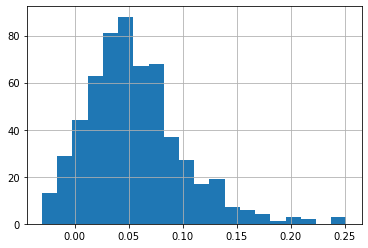

In [158]:
new_df['cap_rate'].hist(bins=20)

In [159]:
new_df.to_csv("./data/test_and_pred_cap_rate.csv",index=False)

In [129]:
def eval_results(model):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print(f'RMSE on Test: {rmse}')
    r2 = r2_score(y_test, preds)
    print(f'R^2 on Test: {r2}')

## As an experiment, try fitting on all data with statsmodels (since that approach is more of stats rather than ml)

In [74]:
X=alldata[list(final_cols)]
y=alldata['LogPrice']
X=alldata.drop(['SalePrice','LogPrice'],axis=1)

In [75]:
import statsmodels.api as sm
x = sm.add_constant(X)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y,x)
results = model.fit()
print(results.summary()) # How to print out the summary report

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     139.2
Date:                Sat, 13 Aug 2022   Prob (F-statistic):               0.00
Time:                        11:41:26   Log-Likelihood:                 2432.5
No. Observations:                2558   AIC:                            -4339.
Df Residuals:                    2295   BIC:                            -2801.
Df Model:                         262                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.53

In [298]:
import statsmodels.api as sm
x = sm.add_constant(X)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y,x)
results = model.fit_regularized(method='elastic_net', alpha=0.0, L1_wt=1.0, start_params=None, profile_scale=False, refit=False)

print(results.summary()) # How to print out the summary report

NotImplementedError: 

In [141]:
import statsmodels.api as sm
x = sm.add_constant(X_train)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train,x)
results = model.fit()
print(results.summary()) # How to print out the summary report

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     238.1
Date:                Mon, 15 Aug 2022   Prob (F-statistic):               0.00
Time:                        08:13:30   Log-Likelihood:                 1660.3
No. Observations:                2046   AIC:                            -3129.
Df Residuals:                    1950   BIC:                            -2589.
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.6803 

In [100]:
# pipe = make_pipeline(StandardScaler(),PolynomialFeatures(2),LinearRegression())
# model_poly=run_model(pipe,X_train,y_train,X_test,y_test)